In [1]:
import numpy as np
from scipy.linalg import eig
from scipy.sparse.linalg import eigs
from scipy.sparse import eye, diags
import kwant

import matplotlib.pyplot as plt

In [2]:
%%time
N = 10000
a = 0.1
Emax = 1
Emin = -1

E_max_abs = np.max(np.abs([Emax, Emin]))

H = diags(np.linspace(Emin, Emax, N))

def G_operator(ham, Emax, Emin):
    Emax=Emax+0.05
    Emin=Emin-0.05
    E0 = (Emax - Emin)/2
    Ec = (Emax + Emin)/2
    return (ham - eye(ham.shape[0]) * Ec)/E0


def F_operator(ham, Emax, a):
    Emax=Emax+0.05
    E0 = (Emax**2 - a**2)/2
    Ec = (Emax**2 + a**2)/2
    return (ham @ ham - eye(ham.shape[0]) * Ec)/E0

G = G_operator(H, Emax, Emin)
F = F_operator(H, E_max_abs, a)
a_r = a/E_max_abs


dos_estimate = kwant.kpm.SpectralDensity(
    H,
    energy_resolution=2*a,
    mean=True,
    bounds=(Emin, Emax)
)

d = int(np.abs(dos_estimate(0))*2*a)

CPU times: user 55.9 ms, sys: 11.8 ms, total: 67.8 ms
Wall time: 68.7 ms


In [3]:
def low_E_filter(ψ_rand, H, k):
    for i in range(k+1):
        if i == 0:
            ψ_n = ψ_rand
            continue
            
        if i == 1:
            ψ_nm1 = ψ_n
            ψ_n = H.dot(ψ_nm1)
            continue
            
        ψ_np1 = 2*H.dot(ψ_n) - ψ_nm1
        ψ_nm1 = ψ_n
        ψ_n = ψ_np1
        
    return ψ_n

def basis(ψ_proj, H, indices):
    ψ_basis = []
    k = indices[-1]
    for i in range(k+1):
        if i == 0:
            ψ_n = ψ_proj
            continue
            
        if i == 1:
            ψ_nm1 = ψ_n
            ψ_n = H.dot(ψ_nm1)
            continue
            
        ψ_np1 = 2*H.dot(ψ_n) - ψ_nm1
        ψ_nm1 = ψ_n
        ψ_n = ψ_np1
        
        if i in indices:
            ψ_basis.append(ψ_n)
    return ψ_basis

CPU times: user 49 ms, sys: 2.23 ms, total: 51.2 ms
Wall time: 48.1 ms


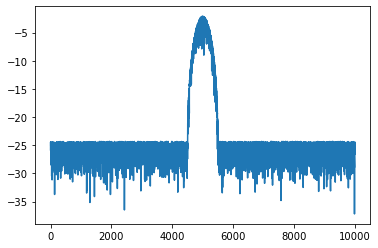

In [4]:
%%time
ψ_rand = np.random.rand(N)
ψ_rand = ψ_rand/np.linalg.norm(ψ_rand)
ψ_proj = low_E_filter(ψ_rand, F, int(12/a))
ψ_proj = ψ_proj/np.linalg.norm(ψ_proj)

plt.plot(np.log(np.abs(ψ_proj)))

In [5]:
%%time
n = int((d*2 - 1)/2)
Kd = int(n*np.pi/a_r)
indices = np.arange(np.pi/a_r, (n+1)*np.pi/a_r, np.pi/a_r).astype(int)

ψ_basis = basis(ψ_proj, G, indices) ## The bottleneck step

norm = np.linalg.norm(ψ_basis, axis=1)
ψ_basis = ψ_basis/norm[:, np.newaxis]

CPU times: user 2.05 s, sys: 266 ms, total: 2.31 s
Wall time: 2.31 s


In [6]:
%%time
S = ψ_basis@ψ_basis.T
H_proj = ψ_basis@H.dot(ψ_basis.T)

CPU times: user 1.02 s, sys: 134 ms, total: 1.15 s
Wall time: 1.15 s


In [7]:
%%time
s, V = eig(S)
indx = np.abs(s)>1e-12
lambda_s = np.diag(1/np.sqrt(s[indx]))
U = V[:, indx]@lambda_s

H_proj_red = U.T.conj()@H_proj@U

CPU times: user 1.2 s, sys: 57.3 ms, total: 1.25 s
Wall time: 1.24 s


In [17]:
%%time
# could use eigh, H_proj_red is approximately hermitian
eigvalues, eigvectors = eig(H_proj_red)

CPU times: user 2.02 s, sys: 52.1 ms, total: 2.07 s
Wall time: 2.04 s


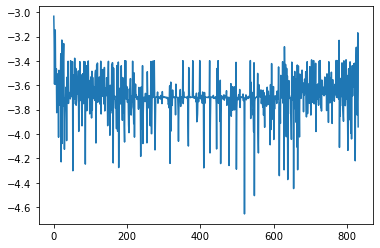

In [18]:
plt.plot(np.log10(np.diff(np.sort(np.real(eigvalues)))))

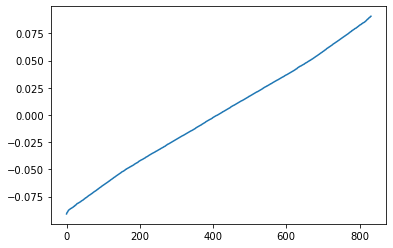

In [19]:
plt.plot(np.sort(np.real(values)))